<a href="https://colab.research.google.com/github/SamuelaAnastasi/Convolution_Maxpooling/blob/master/Convolution_Maxpooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Layer with Filters
Defining different filters for sharpening/blurring an image in a convolutional layer. 

In [0]:
from google.colab import drive
drive.mount('/gdrive')

### Import the image

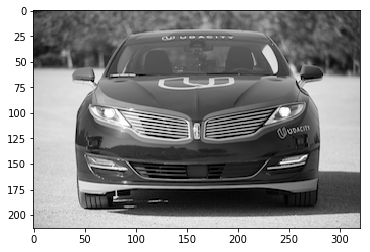

In [37]:
import cv2
import matplotlib.pyplot as plt

img_path = '/gdrive/My Drive/Colab Notebooks/udacity_sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

### Define and visualize the filters
Initialize the weights of the convolutional layer by defining 4 kernels. In real scenarios the weights are going to be learned by the network.

In [38]:
import numpy as np

# define filter
filter_vals = np.array([[-1, -1, 0, 1, 1], [-1, -1, 0, 1, 1], [-1, -1, 0, 1, 1], [-1, -1,0, 1, 1], [-1, -1, 0, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (5, 5)


In [39]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[-1 -1  0  1  1]
 [-1 -1  0  1  1]
 [-1 -1  0  1  1]
 [-1 -1  0  1  1]
 [-1 -1  0  1  1]]


In [40]:

weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
k_height, k_width = weight.shape[2:]
k_height

5

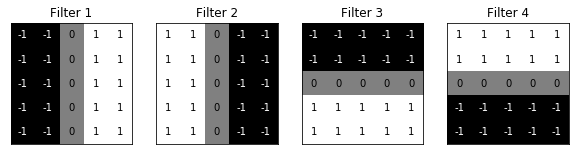

In [41]:
# visualize all four filters
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

##Convolutional layer 

Define Convolutional layer that uses all 4 filters to visualize what happens after a forward pass through this network.

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# neural network with 1 conv layer and 4 filters
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False, padding=2)
        self.conv.weight = torch.nn.Parameter(weight)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # returns both layers
        return conv_x, activated_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model2 = Net(weight)

# print out the layer in the network
print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)


### Visualize the output of each filter

Define a helper function, `viz_layer` that takes in a specific layer and number of filters, and displays the output of the layer once an image has been passed through.

In [0]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

Output of a convolutional layer, before and after a ReLu activation function is applied.

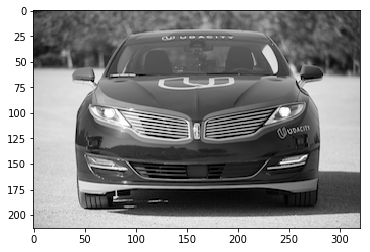

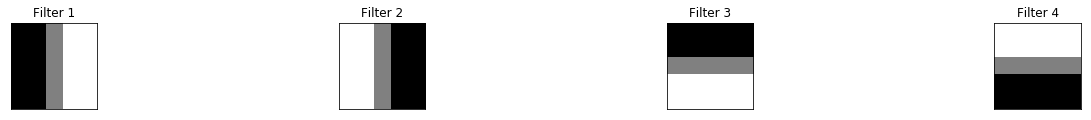

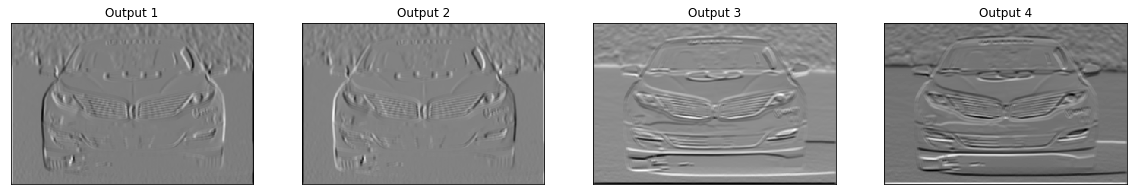

In [48]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)

# visualize the output of a conv layer
viz_layer(conv_layer)

#### ReLu activation

Pass the conv layer to ReLu to scale its output between 0 and 1 

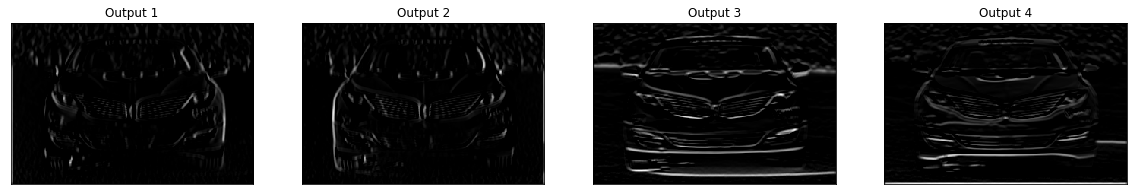

In [49]:
# after a ReLu is applied
# visualize the output of an activated conv layer
viz_layer(activated_layer)

###Modify Network class to contain pooling layer

Use kernel size 2x2 toe reduce layer size by a factor of 2

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a convolutional layer with four filters
# AND a pooling layer of size (2, 2)
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # assumes there are 4 grayscale filters
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        # define a pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # applies pooling layer
        pooled_x = self.pool(activated_x)
        
        # returns all layers
        return conv_x, activated_x, pooled_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

# print out the layer in the network
print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [0]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

###Output after maxpool layer is added

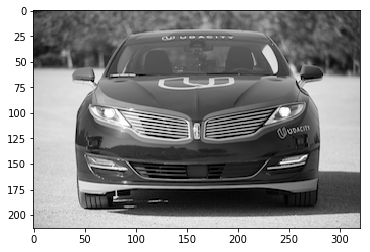

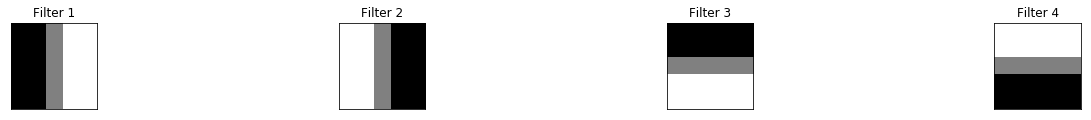

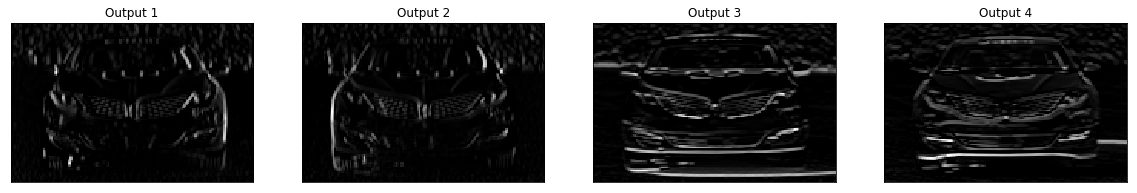

In [51]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers 
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the activated conv layer
viz_layer(pooled_layer)